In [1]:
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras import backend as K
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

/opt/ds/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/opt/ds/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:

TRAIN_DIR = 'data/image/animal/train2/'
TEST_DIR = 'data/image/animal/test2/'

# resizes the images to 256x256 
ROWS = 256
COLS = 256
ROWS2 = 64
COLS2 = 64
CHANNELS = 3

#train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]


# slice datasets for memory efficiency on Kaggle Kernels, delete if using full dataset
train_images =  train_cats[:100] + train_dogs[:100] #train_dogs[:10000] + train_cats[:10000]
random.shuffle(train_images)
test_images = test_images[:100] #test_images[:1000]

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    b,g,r = cv2.split(img)
    img2 = cv2.merge([r,g,b])
    return cv2.resize(img2, (ROWS2, COLS2), interpolation=cv2.INTER_CUBIC)

def read_image2(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    b,g,r = cv2.split(img)
    img2 = cv2.merge([r,g,b])
    return cv2.resize(img2, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS2, COLS2), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%1000 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

def prep_data2(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image2(image_file)
        data[i] = image.T
        if i%500 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

train = prep_data(train_images)
test = prep_data(test_images)
test2 = prep_data2(test_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Processed 0 of 200
Processed 0 of 100
Processed 0 of 100
Train shape: (200, 3, 64, 64)
Test shape: (100, 3, 64, 64)


/opt/ds/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


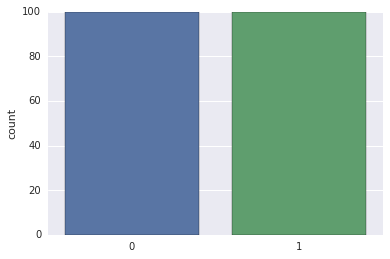

In [3]:
labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

sns.countplot(labels)


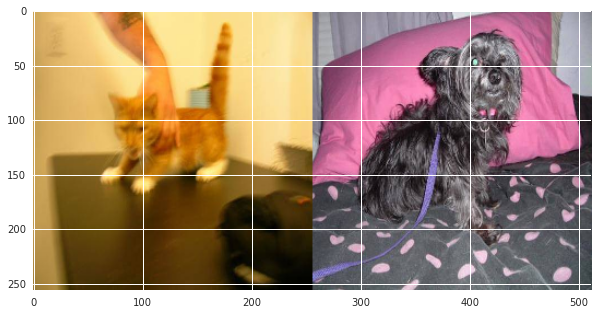

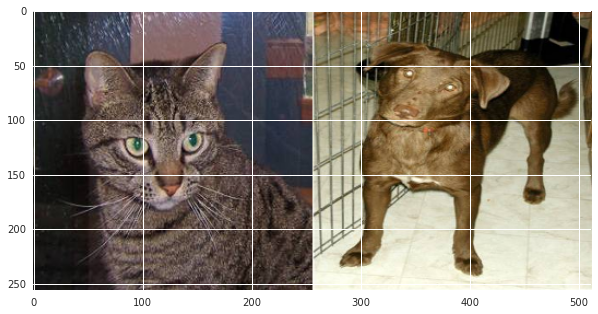

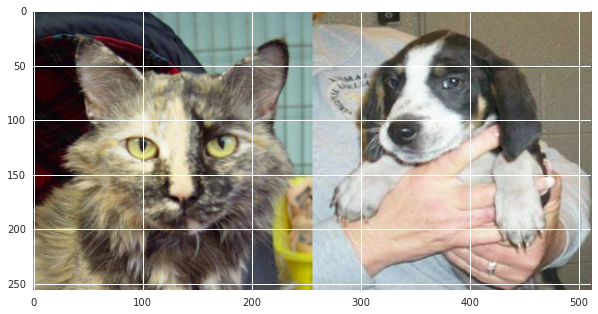

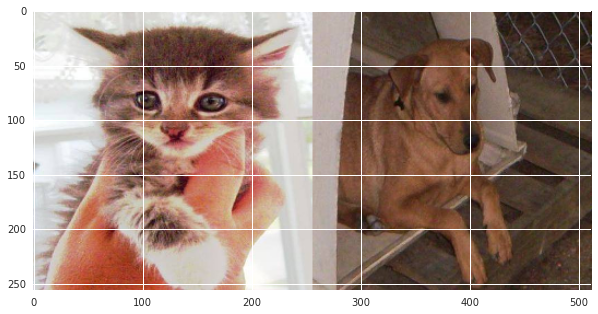

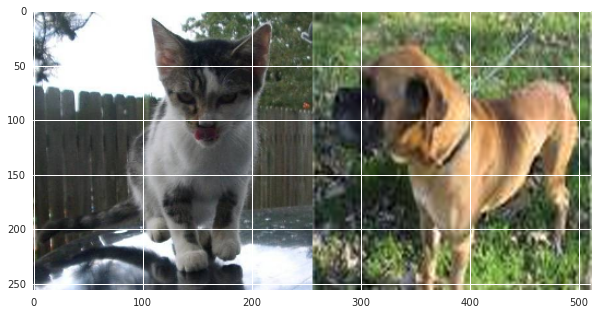

In [4]:
def show_cats_and_dogs(idx):
    cat = read_image2(train_cats[idx])
    dog = read_image2(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
for idx in range(0,5):
    show_cats_and_dogs(idx)

In [ ]:

optimizer = RMSprop(lr=1e-4)


In [ ]:

objective = 'binary_crossentropy'


In [5]:

def catdog():
    
    model = Sequential()

    model.add(Conv2D(32, 3, padding='same', input_shape=train.shape[1:], activation='relu'))
    model.add(Conv2D(32, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    #print("First layer...")
    model.add(Conv2D(64, 3, padding='same', activation='relu'))
    model.add(Conv2D(64, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    #print("Second layer...")
    model.add(Conv2D(128, 3, padding='same', activation='relu'))
    model.add(Conv2D(128, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    #print("Third layer...")
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))

    #model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    #model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    #model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    #print("Flattening, etc...")
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    print("Compiling model...")
    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model

print("Creating model:")
model = catdog()

Creating model:
Compiling model...


running model...
Train on 150 samples, validate on 50 samples
Epoch 1/10
 - 6s - loss: 2.8972 - acc: 0.4400 - val_loss: 1.0549 - val_acc: 0.4600
Epoch 2/10
 - 4s - loss: 1.0951 - acc: 0.5333 - val_loss: 0.8162 - val_acc: 0.4600
Epoch 3/10
 - 4s - loss: 0.8357 - acc: 0.5600 - val_loss: 0.7274 - val_acc: 0.5400
Epoch 4/10
 - 3s - loss: 0.8520 - acc: 0.5000 - val_loss: 0.7135 - val_acc: 0.5400
Epoch 5/10
 - 3s - loss: 0.8921 - acc: 0.5400 - val_loss: 0.7161 - val_acc: 0.4200
Epoch 6/10
 - 3s - loss: 0.8451 - acc: 0.5533 - val_loss: 0.7093 - val_acc: 0.5400
Epoch 7/10
 - 3s - loss: 1.0762 - acc: 0.4333 - val_loss: 0.8444 - val_acc: 0.4600
Epoch 8/10
 - 5s - loss: 0.8975 - acc: 0.4533 - val_loss: 0.7989 - val_acc: 0.4600
Epoch 9/10
 - 4s - loss: 0.8194 - acc: 0.4867 - val_loss: 0.7053 - val_acc: 0.4400
Epoch 10/10
 - 4s - loss: 0.7323 - acc: 0.5667 - val_loss: 0.7076 - val_acc: 0.4200
making predictions on test set...


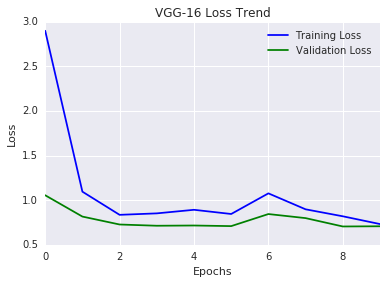

In [6]:
epochs = 10
batch_size = 16

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
       

def run_catdog():
    
    history = LossHistory()
    print("running model...")
    model.fit(train, labels, batch_size=batch_size, epochs=epochs,
              validation_split=0.25, verbose=2, shuffle=True, callbacks=[history, early_stopping])
    
    print("making predictions on test set...")
    predictions = model.predict(test, verbose=0)
    return predictions, history

predictions, history = run_catdog()

loss = history.losses
val_loss = history.val_losses


plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

I am 51.54% sure this is a Cat


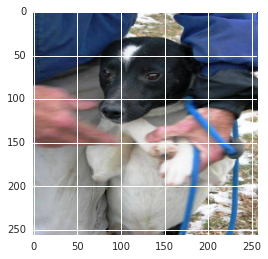

I am 53.63% sure this is a Dog


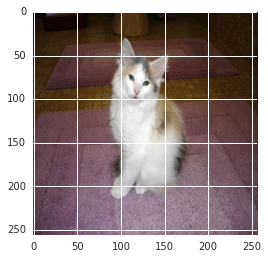

I am 50.40% sure this is a Cat


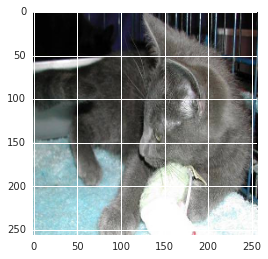

I am 50.41% sure this is a Dog


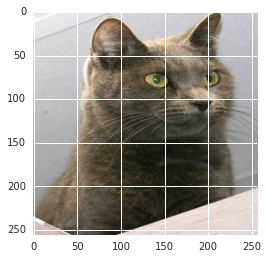

I am 50.41% sure this is a Dog


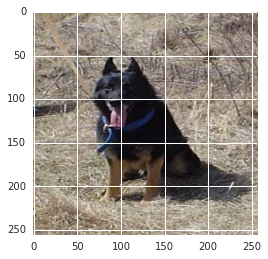

I am 51.18% sure this is a Dog


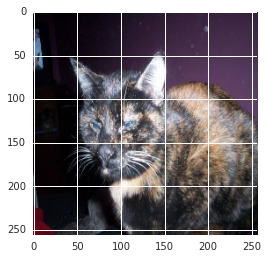

I am 51.53% sure this is a Cat


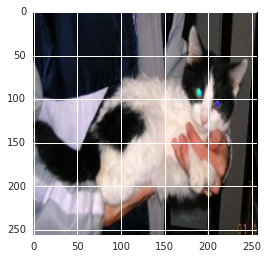

I am 51.45% sure this is a Dog


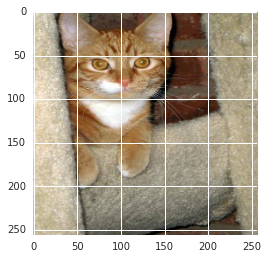

I am 50.65% sure this is a Dog


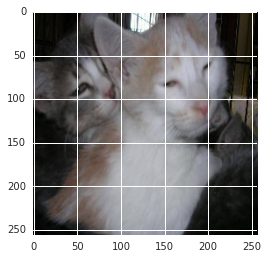

I am 52.72% sure this is a Cat


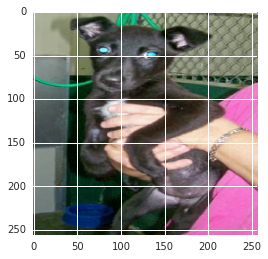

In [7]:

for i in range(0,10):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(test2[i].T)
    plt.show()